In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gym # OpenAI Gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import tensorflow as tf

In [3]:

dataset = pd.read_csv('data/dataset.csv', index_col='time', parse_dates=True)
dataset.drop(['active_power', 'voltage'], inplace=True, axis=1)
dataset['consumption'].fillna(method='ffill', inplace=True)
dataset['generation'].fillna(method='ffill', inplace=True)

pv_size = 5
battery_capacity = 10000
dataset['generation'] = dataset['generation'] * pv_size

In [4]:
print(f"max consumption: {dataset['consumption'].max()}")
print(f"max generation: {dataset['generation'].max()}")

max consumption: 3421.579043
max generation: 4515.2


Rule Based Bench marking: 

In [5]:
grid_import = []
battery_level = np.zeros(len(dataset))
excess = 0

for i in range(0, len(dataset)):
    
    if i>0 : battery_level[i] = battery_level[i-1]
    else: battery_level[i] = 0
    
    if dataset['generation'][i] >= dataset['consumption'][i]:
        excess = dataset['generation'][i] - dataset['consumption'][i]
        battery_level[i] = min (battery_capacity, battery_level[i] + excess)
        grid_import.append(0)
    else:
        if battery_level[i] >= dataset['consumption'][i] - dataset['generation'][i]:
            battery_level[i] = battery_level[i] - (dataset['consumption'][i] - dataset['generation'][i])
            grid_import.append(0)
        else:
            grid_import.append(dataset['consumption'][i] - dataset['generation'][i] - battery_level[i])
            battery_level[i] = 0

dataset['grid_import_rb'] = grid_import
dataset['battery_level_rb'] = battery_level

In [6]:
total_grid_import = np.sum(grid_import)
total_pv_generation = np.sum(dataset['generation'])
pv_self_consumption = ((total_pv_generation - total_grid_import)/ total_pv_generation) * 100
electricity_bill = np.sum(grid_import * dataset['price'])/1000000
    
print(f"pv self consumption: {pv_self_consumption:.2f}%")
print(f"total pv generation: {total_pv_generation/1000:.2f} kWh")
print(f"total grid import: {np.sum(grid_import)/1000:.2f} kWh")
print(f"total consumption: {np.sum(dataset['consumption'])/1000:.2f} kWh")
print(f'average battery level: {np.mean(battery_level)/1000:.2f} kWh')
print(f'electricity bill: {electricity_bill:.2f} €')

pv self consumption: 88.84%
total pv generation: 20780.88 kWh
total grid import: 2319.29 kWh
total consumption: 14156.89 kWh
average battery level: 5.58 kWh
electricity bill: 304.04 €


In [7]:

class EnergyEnv(gym.Env):
    def __init__(self, generation, consumption, price, battery_capacity):
        super(EnergyEnv, self).__init__()
        self.generation = generation
        self.consumption = consumption
        self.battery_capacity = battery_capacity
        self.price = price
        self.current_step = 0
        self.battery_level = 0  # Initial battery level in Wh
        self.grid_import = 0  # Total grid import in Wh

        # Define action and observation space
        self.action_space = spaces.Discrete(3)  # 0: Do nothing, 1: Charge, 2: Discharge
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0]),
            high=np.array([battery_capacity, max(generation), max(consumption)]),
            dtype=np.float32
        )
        
    def seed(self, seed=None):
        self.np_random, seed = np.random.default_rng(seed), seed
        return [seed]
    
    def reset(self):
        self.current_step = 0
        self.battery_level = 0
        return self._get_state()
    
    def _get_state(self):
        return np.array([
            self.battery_level,
            self.generation[self.current_step],
            self.consumption[self.current_step]
        ], dtype=np.float32)
    
    def step(self, action):
        # Get current generation and consumption
        pv_gen = self.generation[self.current_step]
        load = self.consumption[self.current_step]
        
        # Perform action
        if action == 1:  # Charge
            excess_pv = pv_gen - load
            load = max(0, load - pv_gen)
            if excess_pv > 0:
                self.battery_level = min(self.battery_level + excess_pv, self.battery_capacity)
                reward = 10 * excess_pv
            else:
                reward = -5 * excess_pv
                   
        elif action == 2:  # Discharge
            deficit = load - pv_gen
            if deficit > 0:
                discharge = min(deficit, self.battery_level)
                self.battery_level -= discharge
                load = deficit - discharge
                reward = 10 * discharge
            else:
                discharge = 0
                load = max(0, load - pv_gen)
                reward = 2 * deficit  # Negative reward for wrong discharge
                
        elif action == 0:
            if (pv_gen > load) & (self.battery_level < self.battery_capacity):
                excess_pv = pv_gen - load
                self.battery_level = min(self.battery_level + excess_pv, self.battery_capacity)
                load = 0
                reward = -2 * excess_pv
            elif (pv_gen > load) & (self.battery_level == self.battery_capacity):
                load = 0
                reward = 0
            elif (pv_gen < load) & (self.battery_level > 0):
                deficit = load - pv_gen
                discharge = min(deficit, self.battery_level)
                self.battery_level -= discharge
                load = deficit - discharge
                reward = -5 * discharge
            elif (pv_gen < load) & (self.battery_level == 0):
                deficit = load - pv_gen
                load = deficit
                reward = 0
            else:
                load = min(0, load - pv_gen)
                reward = 2 * pv_gen
                
        # Calculate reward
        self.grid_import = load 
        reward += -self.grid_import - self.battery_level # Negative reward for grid dependency
        
        # Update step
        self.current_step += 1
        done = self.current_step >= len(self.generation)
        next_state = self._get_state() if not done else None
        
        return next_state, reward, done, {}
    
    def render(self):
        print(f"Step: {self.current_step}, Battery Level: {self.battery_level:.2f} Wh, Grid Import: {self.grid_import:.2f} Wh")



generation = dataset['generation'].values
consumption = dataset['consumption'].values
price = dataset['price'].values

# Initialize the environment
env = EnergyEnv(generation, consumption, price, battery_capacity=battery_capacity)
vec_env = make_vec_env(lambda: env, n_envs=1)

# Initialize the PPO agent
model = PPO("MlpPolicy", vec_env, verbose=1)

# Train the agent
model.learn(total_timesteps= len(generation))

# # Save the model
# model.save("energy_agent")


# # Load the trained agent
# model = PPO.load("energy_agent")

# Reset the environment
state = env.reset()
done = False

while not done:
    action, _ = model.predict(state)
    state, reward, done, _ = env.step(action)
    env.render()

/home/hossein/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/hossein/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 3248 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 2213          |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 2.7674832e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | -1.17e-05     |
|    learning_rate        | 0.0003        |
|    loss                 | 5.17e+09      |
|    n_updates            | 10            |
|    policy_gradient_loss | -2.35e-05     |
|    value_loss           | 9.96e+09      |
-------------------------

In [8]:
env.reset()
states, actions, rewards, battery_level, grid_import, pv_generation, consumption = [], [], [], [], [], [], []

done = False
while not done:
    state = env._get_state()
    action, _ = model.predict(state)
    next_state, reward, done, _ = env.step(action)
    
    # Save data for visualization
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    battery_level.append(env.battery_level)
    grid_import.append(env.grid_import)  # Grid import
    pv_generation.append(state[1])
    consumption.append(state[2])

# Convert lists to numpy arrays for easier plotting
battery_levels_rl = np.array(battery_level)
grid_imports_rl = np.array(grid_import)
pv_generation = np.array(pv_generation)
consumption = np.array(consumption)

dataset['battery_level_rl'] = battery_level
dataset['grid_import_rl'] = grid_import

In [9]:
pv_self_consumption = np.sum(pv_generation - grid_import) / np.sum(pv_generation) * 100
electricity_bill = np.sum(grid_import * dataset['price']) / 1000000
    
print(f"pv self consumption: {pv_self_consumption:.2f}%")
print(f"total pv generation: {np.sum(pv_generation)/1000:.2f} kWh")
print(f"total grid import: {np.sum(grid_import)/1000:.2f} kWh")
print(f"total consumption: {np.sum(consumption)/1000:.2f} kWh")
print(f'average battery level: {np.mean(battery_level)/1000:.2f} kWh')
print(f'electricity bill: {electricity_bill:.2f} €')

pv self consumption: 79.54%
total pv generation: 20780.88 kWh
total grid import: 4252.72 kWh
total consumption: 14156.89 kWh
average battery level: 6.03 kWh
electricity bill: 520.16 €


In [34]:
import gym
import numpy as np
from stable_baselines3 import DQN
# from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from torch import nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import os

        
class RewardShapingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardShapingCallback, self).__init__(verbose)

    def _on_step(self):
        # Get the reward from the environment
        reward = self.locals['rewards'][0]  # Rewards for the current timestep

        # Apply reward shaping
        if reward < 0:  # Penalize for high grid import and overcharging
            self.locals['rewards'][0] -= 5  # Stronger penalty for grid imports or overcharging
        if self.locals['rewards'][0] > 0 and self.locals['rewards'][0] < 10:  # More refined positive reward range
            self.locals['rewards'][0] += 1  # Small reward for good actions

        return True

class EnergyEnv(gym.Env):
    def __init__(self, generation, consumption, price, battery_capacity):
        super(EnergyEnv, self).__init__()
        self.generation = generation
        self.consumption = consumption
        self.battery_capacity = battery_capacity
        self.price = price
        self.current_step = 0
        self.battery_level = 0  # Initial battery level in Wh
        self.grid_import = 0  # Total grid import in Wh

        # Define action and observation space
        self.action_space = spaces.Discrete(3)  # 0: Do nothing, 1: Charge, 2: Discharge
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0]),
            high=np.array([battery_capacity, max(generation), max(consumption)]),
            dtype=np.float32
        )
        
    def seed(self, seed=None):
        self.np_random, seed = np.random.default_rng(seed), seed
        return [seed]
    
    def reset(self):
        self.current_step = 0
        self.battery_level = 0
        return self._get_state()
    
    def _get_state(self):
        return np.array([
            self.battery_level,
            self.generation[self.current_step],
            self.consumption[self.current_step]
        ], dtype=np.float32)
    
    def step(self, action):
        # Get current generation and consumption
        pv_gen = self.generation[self.current_step]
        load = self.consumption[self.current_step]
        current_price = self.price[self.current_step]
        
        # Perform action
        if action == 1:  # Charge
            excess_pv = pv_gen - load
            load = max(0, load - pv_gen)
            if excess_pv > 0:
                self.battery_level = min(self.battery_level + excess_pv, self.battery_capacity)
                reward = 10 * excess_pv  # Reward for charging with excess PV
            else:
                reward = -5 * excess_pv  # Penalize undercharging or inefficiency
                
        elif action == 2:  # Discharge
            deficit = load - pv_gen
            if deficit > 0:
                discharge = min(deficit, self.battery_level)
                self.battery_level -= discharge
                load = deficit - discharge
                reward = 10 * discharge  # Reward for discharging battery to cover deficit
            else:
                discharge = 0
                load = max(0, load - pv_gen)
                reward = -2 * deficit  # Penalize incorrect discharge when not needed
                
        elif action == 0:  # Do nothing
            if (pv_gen > load) & (self.battery_level < self.battery_capacity):
                excess_pv = pv_gen - load
                self.battery_level = min(self.battery_level + excess_pv, self.battery_capacity)
                load = 0
                reward = -2 * excess_pv  # Penalize for not using excess PV for charging
            elif (pv_gen > load) & (self.battery_level == self.battery_capacity):
                load = 0
                reward = 0  # No need to charge, already full
            elif (pv_gen < load) & (self.battery_level > 0):
                deficit = load - pv_gen
                discharge = min(deficit, self.battery_level)
                self.battery_level -= discharge
                load = deficit - discharge
                reward = -5 * discharge  # Penalize for unnecessary discharge
            elif (pv_gen < load) & (self.battery_level == 0):
                deficit = load - pv_gen
                load = deficit
                reward = 0  # No battery, just grid import
            else:
                load = min(0, load - pv_gen)
                reward = 2 * pv_gen  # Reward for using PV directly for consumption
                
        # Calculate grid import penalty and battery level effect
        self.grid_import = load 
        reward -= self.grid_import * (current_price)  # Stronger penalty for grid import
        reward -= self.battery_level  # Penalize large battery levels to encourage balance
        
        # Update step
        self.current_step += 1
        done = self.current_step >= len(self.generation)
        next_state = self._get_state() if not done else None
        
        return next_state, reward, done, {}
    
    def render(self):
        print(f"Step: {self.current_step}, Battery Level: {self.battery_level:.2f} Wh, Grid Import: {self.grid_import:.2f} Wh")

generation = dataset['generation'].values
consumption = dataset['consumption'].values
price = dataset['price'].values

# Initialize the environment
env = EnergyEnv(generation, consumption, price, battery_capacity=battery_capacity)
vec_env = make_vec_env(lambda: env, n_envs=1)

# Initialize the DQN agent
# model = DQN("MlpPolicy", vec_env, verbose=1, buffer_size=50000, learning_starts=1000, batch_size=64, tau=0.1)
# Fine-tuning the hyperparameters


class CustomNetwork(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=128):
        super(CustomNetwork, self).__init__(observation_space, features_dim)
        input_dim = observation_space.shape[0]
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, features_dim),
            nn.ReLU()
        )

    def forward(self, observations):
        return self.net(observations)

# Integrate the custom network into the DQN model
policy_kwargs = dict(
    features_extractor_class=CustomNetwork,
    features_extractor_kwargs=dict(features_dim=128),
)


model = DQN("MlpPolicy", vec_env, verbose=1, 
            policy_kwargs=policy_kwargs,
            buffer_size=100000, 
            learning_starts=1000, 
            batch_size=128, 
            tau=0.1, 
            learning_rate=0.0001, 
            gamma=0.99, 
            train_freq=4,  # Update the model every 4 steps
            target_update_interval=1000,  # Update target network after 1000 steps
            exploration_fraction=0.1,  # Use 10% of training steps for exploration
            exploration_final_eps=0.05,  # Final epsilon value after decay
            )


# Train the agent
model.learn(total_timesteps= len(generation))


# Save the model
# model.save("energy_dqn_agent")

# Load the trained agent
# model = DQN.load("energy_dqn_agent")

# Reset the environment
state = env.reset()
done = False

while not done:
    action, _ = model.predict(state)
    state, reward, done, _ = env.step(action)
    env.render()


ValueError: Policy MlpLstmPolicy unknown

In [31]:
env.reset()
states, actions, rewards, battery_level, grid_imports, pv_generation, consumption = [], [], [], [], [], [], []

done = False
while not done:
    state = env._get_state()
    action, _ = model.predict(state)
    next_state, reward, done, _ = env.step(action)
    
    # Save data for visualization
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    battery_level.append(env.battery_level)
    grid_imports.append(env.grid_import)  # Grid import
    pv_generation.append(state[1])
    consumption.append(state[2])

# Convert lists to numpy arrays for easier plotting
battery_levels = np.array(battery_level)
grid_imports = np.array(grid_imports)
pv_generation = np.array(pv_generation)
consumption = np.array(consumption)

dataset['battery_level_rl_dqn'] = battery_level
dataset['grid_import_rl_dqn'] = grid_imports


In [32]:
pv_self_consumption = np.sum(pv_generation - grid_imports) / np.sum(pv_generation) * 100
electricity_bill = np.sum(grid_imports * dataset['price'])/ 1000000 

    
print(f"pv self consumption: {pv_self_consumption:.2f}%")
print(f"total pv generation: {np.sum(pv_generation)/1000:.2f} kWh")
print(f"total grid import: {np.sum(grid_imports)/1000:.2f} kWh")
print(f"total consumption: {np.sum(consumption)/1000:.2f} kWh")
print(f'average battery level: {np.mean(battery_level)/1000:.2f} kWh')
print(f'electricity bill: {electricity_bill:.2f} €')

pv self consumption: 88.42%
total pv generation: 20780.88 kWh
total grid import: 2406.94 kWh
total consumption: 14156.89 kWh
average battery level: 5.60 kWh
electricity bill: 313.77 €


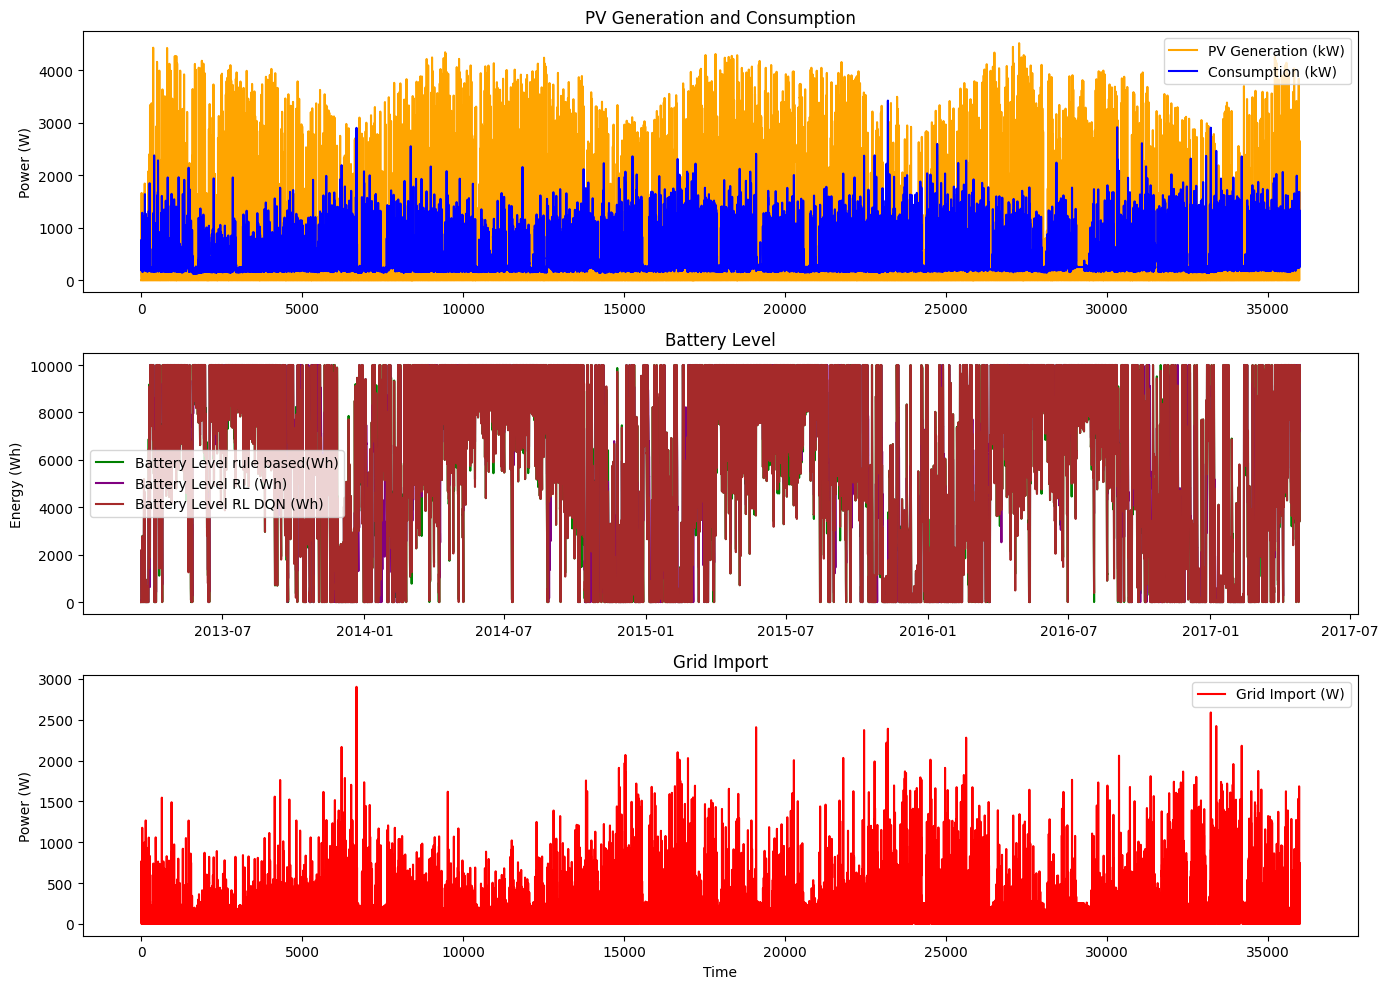

In [19]:
# Generate time labels for a week
time_labels = [f"Day {i//24+1}, Hour {i%24}" for i in range(len(battery_levels))]

# Plot the results
plt.figure(figsize=(14, 10))

# PV Generation and Consumption
plt.subplot(3, 1, 1)
plt.plot(pv_generation, label='PV Generation (kW)', color='orange')
plt.plot(consumption, label='Consumption (kW)', color='blue')
plt.title('PV Generation and Consumption')
plt.ylabel('Power (W)')
plt.legend()

# Battery Level
plt.subplot(3, 1, 2)
plt.plot(dataset['battery_level_rb'], label='Battery Level rule based(Wh)', color='green')
plt.plot(dataset['battery_level_rl'], label='Battery Level RL (Wh)', color='purple')
plt.plot(dataset['battery_level_rl_dqn'], label='Battery Level RL DQN (Wh)', color='brown')
plt.title('Battery Level')
plt.ylabel('Energy (Wh)')
plt.legend()


plt.subplot(3, 1, 3)
plt.plot(grid_import, label='Grid Import (W)', color='red')
plt.title('Grid Import')
plt.ylabel('Power (W)')
plt.xlabel('Time')
plt.legend()

# plt.xticks(ticks=range(0, len(time_labels), 24), labels=[time_labels[i] for i in range(0, len(time_labels), 24)], rotation=45)

plt.tight_layout()
plt.show()
plt.close()